In [19]:
import json
import os
import pickle
import matplotlib.pyplot as plt
import numpy as np
import pickle
import pandas as pd

from collections import namedtuple, defaultdict, Counter
from itertools import groupby, chain, count
from operator import itemgetter
from scipy.spatial.distance import cdist
from tqdm import tqdm

from f723.tools.urs.extraction import assemble_chains

In [2]:
NRLIST_PATH = '/home/mikhail/bioinformatics/data/nrlist_3.76_3.0A.csv'
CIF_DIR = '/home/mikhail/bioinformatics/data/NR_3.0/cif/'
OUT_DIR = '/home/mikhail/bioinformatics/data/NR_3.0/out/'
NRLIST_PATH = '/home/mikhail/bioinformatics/data/nrlist_3.76_3.0A.csv'
DATASET_DIR = '/home/mikhail/bioinformatics/data/dataset_all_60'

MODELS_DIR = '/home/mikhail/bioinformatics/data/sec_struct'

In [3]:
def load_model(pdb_id):
    with open(os.path.join(MODELS_DIR, '{}.pickle'.format(pdb_id)), 'rb') as infile:
        return pickle.load(infile)

In [4]:
with open('/home/mikhail/bioinformatics/data/nonredundant.txt', 'r') as infile:
    nonredundant_chain_ids = {tuple(chain_id.split('.cif1_')) for chain_id in infile.read().splitlines()}

In [5]:
urs_models = {pdb_id: load_model(pdb_id) for pdb_id, _ in nonredundant_chain_ids}

In [6]:
all_chains = assemble_chains(NRLIST_PATH, CIF_DIR, OUT_DIR, MODELS_DIR)

100%|██████████| 1074/1074 [00:45<00:00, 23.40it/s]


In [7]:
chains_map = {}
for chain in all_chains:
    chains_map[chain.pdb_id, chain.id] = chain

In [8]:
def get_pairs(chain):
    pairs = {}
    
    for i, left in enumerate(chain.nts):
        for right in chain.nts[:i + 1]:
            pairs[left.id, right.id] = 'non_bps'
            pairs[right.id, left.id] = 'non_bps'
    
    for attr in ['ss_bps', 'noncanonical_bps']:
        for bp in getattr(chain, attr):
            pairs[bp.nt_left.id, bp.nt_right.id] = attr
            pairs[bp.nt_right.id, bp.nt_left.id] = attr
    
    return pairs


def get_coords(res):
    return [[atom[key] for key in 'XYZ'] for atom in res['ATOMS']]

In [11]:
pair_classes = {}
for pdb_id, chain_id in nonredundant_chain_ids:
    pair_classes[pdb_id, chain_id] = get_pairs(chains_map[pdb_id, chain_id])

In [ ]:
def res_fragment_type(res):
    return 'WING' if res['THREAD'] is None else 'THREAD'


def get_distances_on_sequence(sequence_distance, chain_ids):
    distances = defaultdict(list)
    
    for pdb_id, chain_id in chain_ids:
        pairs = pair_classes[pdb_id, chain_id]
        atoms = [{'coords': get_coords(res), 'dssr': res['DSSR'], 'type': res_fragment_type(res)} 
                 for res in urs_models[pdb_id].chains[chain_id]['RES']]

        for left_i, left in enumerate(atoms):
            right_i = left_i + sequence_distance
            if right_i < len(atoms):
                right = atoms[right_i]
                
                nr = urs_models[pdb_id].NuclRelation(left['dssr'], right['dssr'])
                pair_fragment_type = ' '.join(sorted([left['type'], right['type']]))
                pair_class = pairs[left['dssr'], right['dssr']]

                if len(right['coords']) > 0 and len(left['coords']) > 0:
                    d = np.min(cdist(left['coords'], right['coords'], 'euclidean'))
                    
                    distances['{} {} {}'.format(nr, pair_fragment_type, pair_class)].append(d)
    
    return distances

In [ ]:
distances = [{}] + [get_distances_on_sequence(i, nonredundant_chain_ids) for i in tqdm(range(1, 51))]

In [15]:
all_keys = list(sorted({k for d in distances for k in d.keys()}))

In [23]:
counter = Counter()
for d in distances:
    for key, ds in d.items():
        counter[key] += len(ds)

In [25]:
counter.most_common()

[('LR THREAD WING non_bps', 197391),
 ('LR WING WING non_bps', 144773),
 ('LR THREAD THREAD non_bps', 111724),
 ('LC THREAD WING non_bps', 101968),
 ('SM THREAD THREAD non_bps', 39833),
 ('SM WING WING non_bps', 23814),
 ('SM WING WING ss_bps', 2218),
 ('SM THREAD THREAD noncanonical_bps', 1260),
 ('LC THREAD WING noncanonical_bps', 335),
 ('LR THREAD THREAD noncanonical_bps', 118),
 ('LR THREAD WING noncanonical_bps', 59),
 ('SM WING WING noncanonical_bps', 10),
 ('LR WING WING noncanonical_bps', 3)]

In [24]:
all_keys

['LC THREAD WING non_bps',
 'LC THREAD WING noncanonical_bps',
 'LR THREAD THREAD non_bps',
 'LR THREAD THREAD noncanonical_bps',
 'LR THREAD WING non_bps',
 'LR THREAD WING noncanonical_bps',
 'LR WING WING non_bps',
 'LR WING WING noncanonical_bps',
 'SM THREAD THREAD non_bps',
 'SM THREAD THREAD noncanonical_bps',
 'SM WING WING non_bps',
 'SM WING WING noncanonical_bps',
 'SM WING WING ss_bps']

In [17]:
len(all_keys)

13

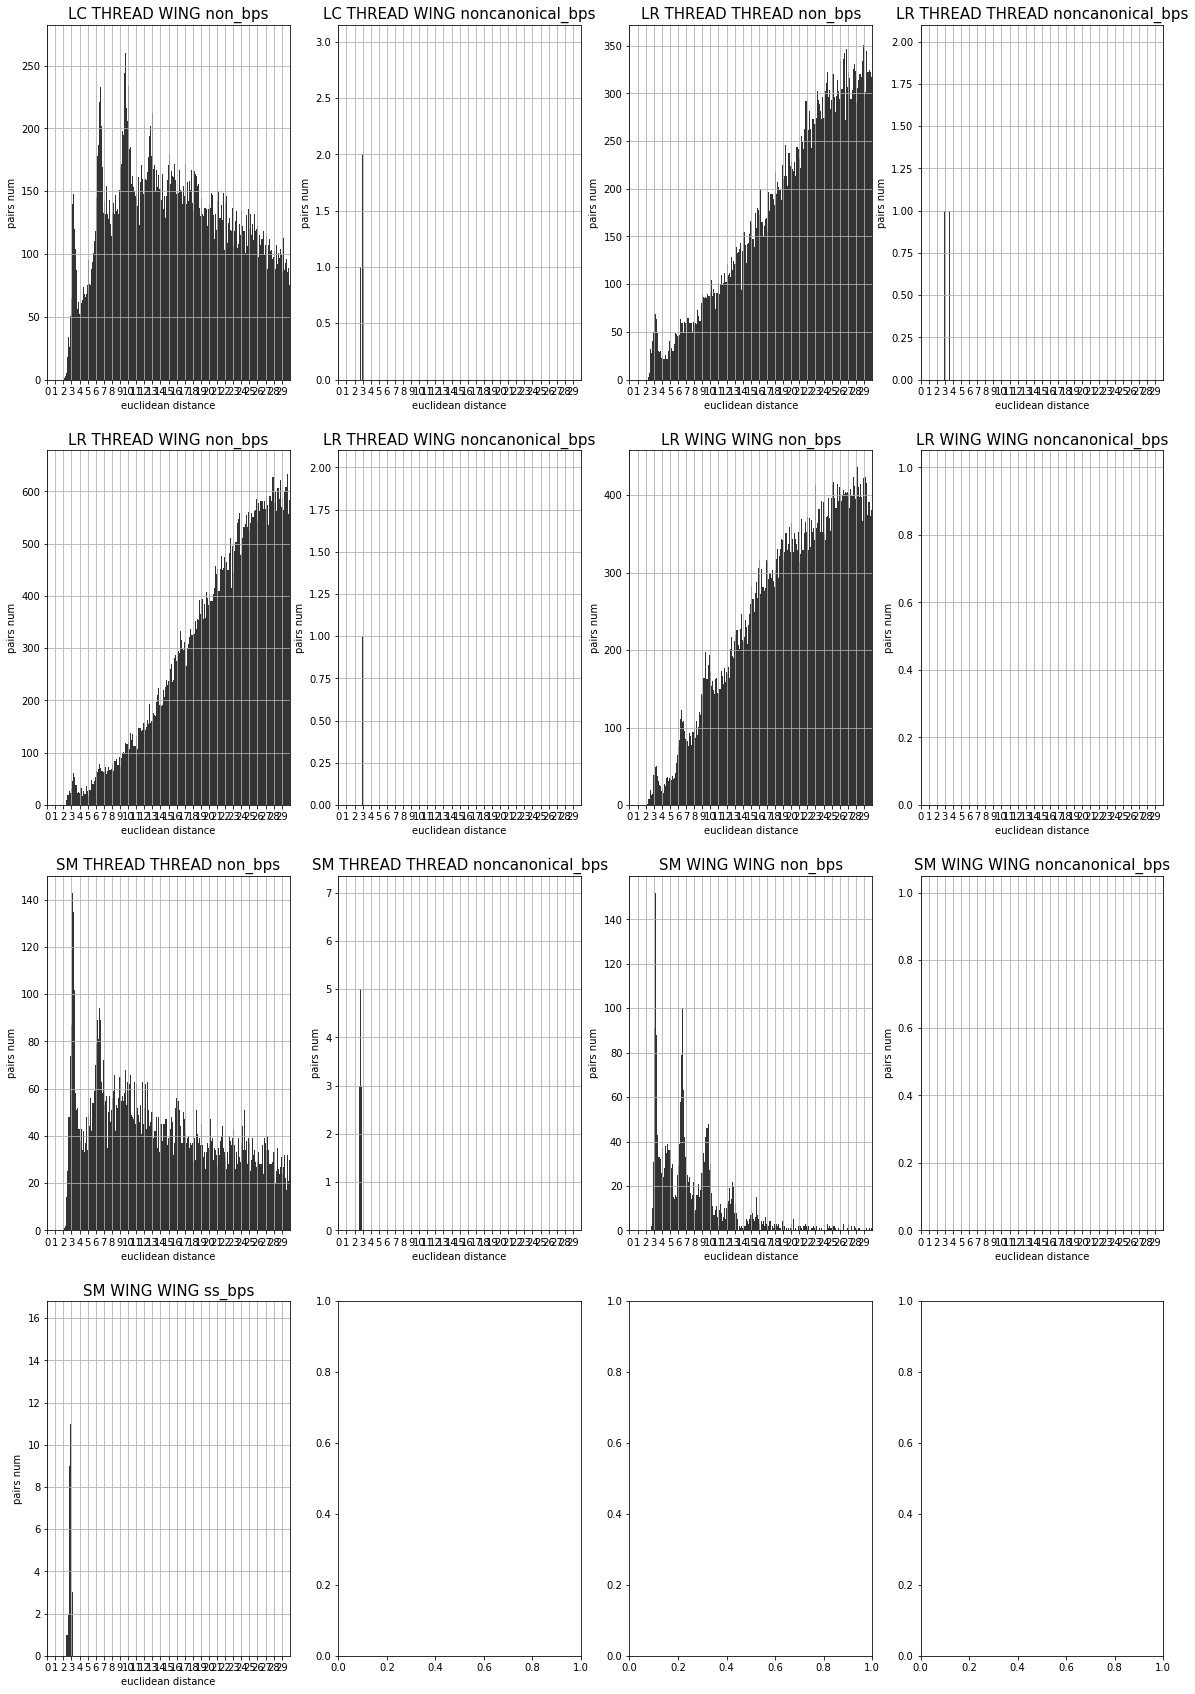

In [21]:
fig, axes = plt.subplots(4, 4, figsize=(20, 30))

for index, ng in enumerate(all_keys):
    i, j = index // 4, index % 4
    ax = axes[i][j]
    
    ax.set_xlim(0, 30)
    ax.set_xticks(np.arange(30))
    ax.set_ylabel('pairs num', fontsize=10)
    ax.set_xlabel('euclidean distance', fontsize=10)
    ax.set_title(ng, fontsize=15)
    ax.grid()

    ax.hist(list(chain.from_iterable([distances[i].get(ng, []) for i in range(10, 51)])), 
             bins=1000, alpha=0.8, label=f'{i}', color='k')

fig.savefig('/home/mikhail/hist.png')